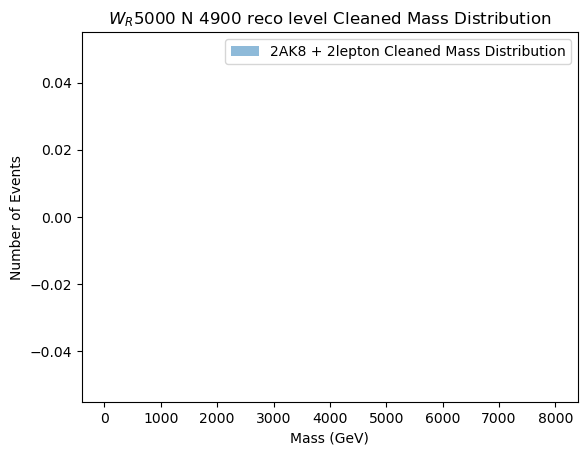

3


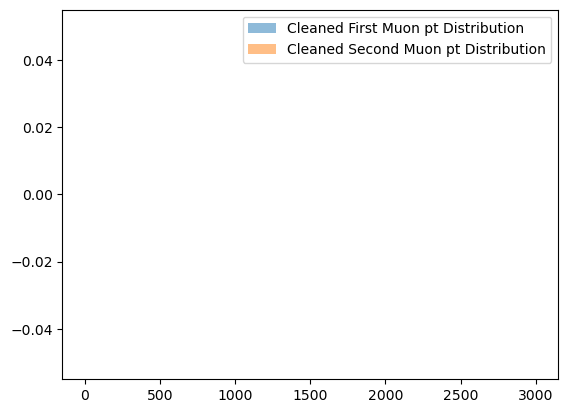

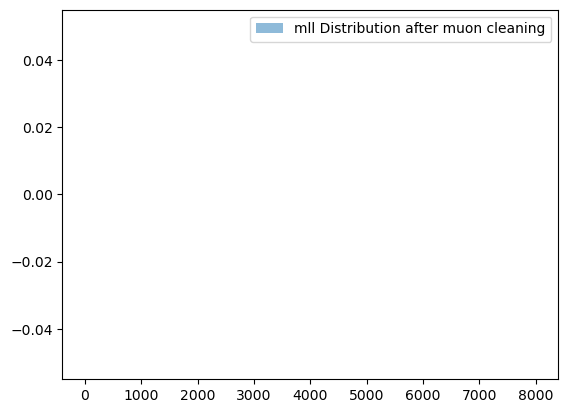

"\n## delta R between ak8 \nak8_deltaR = leading_toptagged_ak8.deltaR(leading_bjet_ak8)\nplt.hist(ak.flatten(ak8_deltaR), bins=100, range=(0, 10), alpha=0.5, label='Delta R between AK8 Jets')\nplt.legend()\nplt.show()\n"

In [ ]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()
## main back  = ttH , ttZ , ttW , ttbar , tzj

#sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root"
#sample = "/gv0/Users/achihwan/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_18.root"
#sample = "/gv0/Users/achihwan/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/tree_100.root"
#sample = "/gv0/Users/achihwan/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
#sample = "/gv0/Users/achihwan/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/tree_13.root"
#sample = "/gv0/Users/achihwan/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
sample = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/cleaning/backgroundsample/08528f47-e513-4c27-9e86-a76cdca78fe8.root" # ttz->mu
file = uproot.open(sample)
events = file["Events"]

keys = events.keys()

def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def btagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btagging[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj["eta"]) < etamax and obj["pt"] > ptmin : output.append(obj)
    return output 




def twoak8cleancut(sample):
    file = uproot.open(sample)
    events = file["Events"]

    keys = events.keys()
    lhe_pdgid = events["LHEPart_pdgId"].array()
    lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()

bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
lhe_muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)

lhe_particle  = ak.zip({
    "pt": lhe_pt,
    "eta": lhe_eta,
    "phi": lhe_phi,
    "mass": lhe_mass
}, with_name = "Momentum4D")

lhe_bottoms = lhe_particle[bottom_mask]
lhe_bottoms_eta = lhe_bottoms["eta"][:, 1:2]  
lhe_bottoms_phi = lhe_bottoms["phi"][:, 1:2]
lhe_bottoms_pt = lhe_bottoms["pt"][:, 1:2]  
lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]  # bottom quark 1 = WR* mother

lhe_bottom2_eta = lhe_bottoms["eta"][:, 0:1]
lhe_bottom2_phi = lhe_bottoms["phi"][:, 0:1]
lhe_bottom2_pt = lhe_bottoms["pt"][:, 0:1]
lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]  # top mother bottom quark

lhe_bottom = ak.zip({
    "eta": lhe_bottoms_eta,
    "phi": lhe_bottoms_phi,
    "pt": lhe_bottoms_pt,
    "mass": lhe_bottoms_mass
}, with_name = "Momentum4D")

lhe_bottom2 = ak.zip({
    "eta": lhe_bottom2_eta,
    "phi": lhe_bottom2_phi,
    "pt": lhe_bottom2_pt,
    "mass": lhe_bottom2_mass
}, with_name = "Momentum4D")

lhe_muons  = lhe_particle[lhe_muon_mask]
lhe_muons_eta = lhe_muons["eta"][:]
lhe_muons_phi = lhe_muons["phi"][:]
lhe_muons_pt = lhe_muons["pt"][:]
lhe_muons_mass = lhe_muons["mass"][:]

n_mother_muon_mass = lhe_muons_mass[:,0:1] 
n_mother_muon_pt = lhe_muons_pt[:,0:1] 
n_mother_muon_eta = lhe_muons_eta[:,0:1]
n_mother_muon_phi = lhe_muons_phi[:,0:1]

wr_mother_muon_mass = lhe_muons_mass[:,1:2]
wr_mother_muon_pt = lhe_muons_pt[:,1:2]
wr_mother_muon_eta = lhe_muons_eta[:,1:2]
wr_mother_muon_phi = lhe_muons_phi[:,1:2]

lhe_muon = ak.zip({
    "pt": lhe_muons_pt,
    "eta": lhe_muons_eta,
    "phi": lhe_muons_phi,
    "mass": lhe_muons_mass
}, with_name = "Momentum4D")

n_mother_muon = ak.zip({
    "pt": n_mother_muon_pt,
    "eta": n_mother_muon_eta,
    "phi": n_mother_muon_phi,
    "mass": n_mother_muon_mass
}, with_name = "Momentum4D")

wr_mother_muon = ak.zip({
    "pt": wr_mother_muon_pt,
    "eta": wr_mother_muon_eta,
    "phi": wr_mother_muon_phi,
    "mass": wr_mother_muon_mass
}, with_name = "Momentum4D")



genparticle_pdgid = events["GenPart_pdgId"].array()
genparticle_pt = events["GenPart_pt"].array()
genparticle_eta = events["GenPart_eta"].array()
genparticle_phi = events["GenPart_phi"].array()
genparticle_mass = events["GenPart_mass"].array()
genparticle_statusFlags = events["GenPart_statusFlags"].array()

top_mask = (genparticle_pdgid == 6) | (genparticle_pdgid == -6)


genparticle  = ak.zip({
    "pt": genparticle_pt,
    "eta": genparticle_eta,
    "phi": genparticle_phi,
    "mass": genparticle_mass
}, with_name = "Momentum4D")



gentops = genparticle[top_mask]
gentops_eta = gentops["eta"][:, 0:1]  
gentops_phi = gentops["phi"][:, 0:1]
gentops_pt = gentops["pt"][:, 0:1]  
gentops_mass = gentops["mass"][:, 0:1]  


gentop = ak.zip({
    "eta": gentops_eta,
    "phi": gentops_phi,
    "pt": gentops_pt,
    "mass": gentops_mass
}, with_name = "Momentum4D")


### reco level
ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

ak4 = ak.zip({
        "pt": ak4_pt,
        "eta": ak4_eta,
        "phi": ak4_phi,
        "mass": ak4_mass
    }, with_name = "Momentum4D")

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

fatjets = ak.zip({
        "pt": fatjet_pt,
        "eta": fatjet_eta,
        "phi": fatjet_phi,
        "mass": fatjet_mass
    }, with_name="Momentum4D")

## muons
reco_muon_pt = events["Muon_pt"].array()
reco_muon_eta = events["Muon_eta"].array()
reco_muon_phi = events["Muon_phi"].array()
reco_muon_mass = events["Muon_mass"].array()

reco_muons = ak.zip({
        "pt": reco_muon_pt,
        "eta": reco_muon_eta,
        "phi": reco_muon_phi,
        "mass": reco_muon_mass
    }, with_name = "Momentum4D")


btagging = events["FatJet_btagDeepB"].array()
toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
softdrop_mass = events["FatJet_msoftdrop"].array()

closest_muon1 = find_closest_jet(n_mother_muon, reco_muons)
closest_muon2 = find_closest_jet(wr_mother_muon, reco_muons)
closest_bjet = find_closest_jet(lhe_bottom, ak4)
closest_bak8jet = find_closest_jet(lhe_bottom, fatjets)
closest_ak8jet = find_closest_jet(gentop, fatjets)
#notcleaned_mass = closest_muon1 + closest_muon2 + closest_bjet + closest_ak8jet
#plt.hist(notcleaned_mass.mass, bins=100, range=(0, 8000), alpha=0.5, label='Not Cleaned Mass Distribution')
#####################################################
cleaned_Nmother_muon_pt = []
cleaned_WR_mother_muon_pt = []
all_muon_pt = []
cleaned_ak4jet_pt = []
all_ak4jet_pt = []
cleaned_ak8jet_pt =[]
all_ak8jet_pt = []
#####################################################


first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온

topmother_b_ak4jet = find_closest_jet(lhe_bottom2, ak4)
### 겹치는거 확인 

first_muon_cleaned = overlap_removal(first_muon, [reco_muons], cut=0.4)
second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)




signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
toptaggedak8 = toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
softdrop_mass_ak8 = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
btaggingak8 = btagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)

idx_desc = ak.argsort(-signaltop_cleaned["pt"], axis=1)

toptagging_mask = toptaggedak8 > 0.9  # ParticleNet T vs QCD threshold
softdrop_mass_mask = (softdrop_mass_ak8 > 120) & (softdrop_mass_ak8 < 250)   # SoftDrop mass threshold
total_top_mask = toptagging_mask & softdrop_mass_mask

cleaned_toptagged_ak8 = signaltop_cleaned[total_top_mask]  # top tagging 된 애들만 남김
idx_cleaned_toptagged_ak8 = ak.argsort(-cleaned_toptagged_ak8["pt"], axis=1)
leading_toptagged_ak8 = cleaned_toptagged_ak8[idx_cleaned_toptagged_ak8][:, 0:1]  # 가장 큰 pt

## top을 제외한 나머지 ak8 중 제일 큰 pt

cleaned_bjet_ak8 = signaltop_cleaned[~toptagging_mask]
idx_cleaned_bjet_ak8 = ak.argsort(-cleaned_bjet_ak8["pt"], axis=1)
leading_bjet_ak8 = cleaned_bjet_ak8[idx_cleaned_bjet_ak8][:, 0:1]  # 가장 큰 pt



### 빈 이벤트 빼고 연산하는 마스크 만들기
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
firstsorted_toptagged_ak8_pt = ak.sum(leading_toptagged_ak8["pt"], axis=1)
firstsorted_bjet_ak8_pt = ak.sum(leading_bjet_ak8["pt"], axis=1)

first_muon_cleaned_eta = ak.sum(first_muon_cleaned["eta"], axis=1)
second_muon_cleaned_eta = ak.sum(second_muon_cleaned["eta"], axis=1)
firstsorted_toptagged_ak8_eta = ak.sum(leading_toptagged_ak8["eta"], axis=1)
firstsorted_bjet_ak8_eta = ak.sum(leading_bjet_ak8["eta"], axis=1)


leftmask = (first_muon_cleaned_pt > 60.0) & (second_muon_cleaned_pt > 53.0) & (firstsorted_toptagged_ak8_pt > 0.0) & (firstsorted_bjet_ak8_pt > 0.0) & (abs(first_muon_cleaned_eta) < 2.4) & (abs(second_muon_cleaned_eta) < 2.4)
#print(len(firstsorted_ak8_pt > 0))
first_muon_cleaned = first_muon_cleaned[leftmask]
second_muon_cleaned = second_muon_cleaned[leftmask]
leading_toptagged_ak8 = leading_toptagged_ak8[leftmask]
leading_bjet_ak8 = leading_bjet_ak8[leftmask]

mll = (first_muon_cleaned + second_muon_cleaned).mass
mll_mask = mll > 200.0
first_muon_cleaned = first_muon_cleaned[mll_mask]
second_muon_cleaned = second_muon_cleaned[mll_mask]
leading_toptagged_ak8 = leading_toptagged_ak8[mll_mask]
leading_bjet_ak8 = leading_bjet_ak8[mll_mask]

combined_p4 = (first_muon_cleaned + second_muon_cleaned + leading_toptagged_ak8 + leading_bjet_ak8).mass
mN = (first_muon_cleaned + leading_toptagged_ak8 + leading_bjet_ak8).mass
first_muon_cleaned_pt = ak.sum(first_muon_cleaned["pt"], axis=1)
second_muon_cleaned_pt = ak.sum(second_muon_cleaned["pt"], axis=1)
mll = (first_muon_cleaned + second_muon_cleaned).mass


'''

plt.hist(ak.flatten(combined_p4.mass), bins=50, range=(0, 8000), alpha=0.5, label='2AK8 + 2lepton Cleaned Mass Distribution')
plt.xlabel('Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('$W_{R}$5000 N 4900 reco level Cleaned Mass Distribution')
mN = (first_muon_cleaned + leading_toptagged_ak8 + leading_bjet_ak8).mass

plt.legend()
plt.show()
#print(len(combined_p4.mass))



##lepton pt 
plt.hist(ak.flatten(first_muon_cleaned["pt"]), bins=100, range=(0, 3000), alpha=0.5, label='Cleaned First Muon pt Distribution')
plt.hist(ak.flatten(second_muon_cleaned["pt"]), bins=100, range=(0, 3000), alpha=0.5, label='Cleaned Second Muon pt Distribution')
plt.legend()
plt.show()
##mll

mll = (first_muon_cleaned + second_muon_cleaned).mass
plt.hist(ak.flatten(mll), bins=100, range=(0, 8000), alpha=0.5, label='mll Distribution after muon cleaning')
plt.legend()
plt.show()

## delta R between ak8 
ak8_deltaR = leading_toptagged_ak8.deltaR(leading_bjet_ak8)
plt.hist(ak.flatten(ak8_deltaR), bins=100, range=(0, 10), alpha=0.5, label='Delta R between AK8 Jets')
plt.legend()
plt.show()
'''

In [ ]:

from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from tqdm import tqdm  # ✅ 진행률 표시
import glob

vector.register_awkward()




def overlap_removal(target, cleans, cut=0.4, dphi=False):
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return target[mask]

def toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return toptagging[mask]

def sdm_toptagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    softdrop_mass = events["FatJet_msoftdrop"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return softdrop_mass[mask]

def btagging_overlap_removal(target, cleans, cut=0.4, dphi=False):
    btagging = events["FatJet_btagDeepB"].array()
    mask = ak.ones_like(target["pt"], dtype=bool)
    for clean in cleans:
        pairs = ak.cartesian([target, clean], nested=True)
        # ΔR 계산
        raw = (pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
        delta = np.abs(raw)
        # 0인 값(=자기 자신)을 무시하기 위해 np.inf로 대체
        nonzero = ak.where(delta > 0, delta, np.inf)
        # 이제 nonzero 중 최소값을 취함 → 사실상 두 번째로 작은 원래 delta
        min_dr = ak.min(nonzero, axis=2)
        mask = mask & (min_dr > cut)
    return btagging[mask]

def overlap_itself_removal(target, cleans, cut=0.4, dphi=False):
            mask = ak.ones_like(target["pt"], dtype=bool)
            for clean in cleans:
                pairs = ak.cartesian([target, clean], nested=True) # axis 0 = #event , axis 1 = target , axis 2 = clean
                delta = np.abs(pairs["0"].deltaphi(pairs["1"]) if dphi else pairs["0"].deltaR(pairs["1"]))
                mask = mask & (ak.min(delta, axis=2) > cut)
            return target[mask]
def find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return jets[closest_idx_per_obj]
def btag_find_closest_jet(obj, jets):
    # obj, jets: both are jagged arrays of shape (n_events,), each sublist = Momentum4D
    pairs = ak.cartesian([obj, jets], nested=True)          # shape: (n_events, N_obj, N_jet)
    dr = pairs["0"].deltaR(pairs["1"])                       # same shape
    # 이벤트별로 obj 하나당 가장 작은 ΔR 의 jet index
    closest_idx_per_obj = ak.argmin(dr, axis=2)              # shape = (n_events, N_obj)
    return btagging[closest_idx_per_obj]
def Select(inputcoll,etamax,ptmin) :
    output = []
    for obj in inputcoll :
        if abs(obj["eta"]) < etamax and obj["pt"] > ptmin : output.append(obj)
    return output 

def twoak8cleancut(sample):
    file = uproot.open(sample)
    events = file["Events"]
    keys = events.keys()
    # LHE-level particles
    lhe_pdgid = events["LHEPart_pdgId"].array()
    lhe_pt    = events["LHEPart_pt"].array()
    lhe_eta   = events["LHEPart_eta"].array()
    lhe_phi   = events["LHEPart_phi"].array()
    lhe_mass  = events["LHEPart_mass"].array()

    bottom_mask     = (lhe_pdgid == 5) | (lhe_pdgid == -5)
    lhe_muon_mask   = (lhe_pdgid == 13) | (lhe_pdgid == -13)
    lhe_particle    = ak.zip({
        "pt":   lhe_pt,
        "eta":  lhe_eta,
        "phi":  lhe_phi,
        "mass": lhe_mass
    }, with_name="Momentum4D")

    lhe_bottoms     = lhe_particle[bottom_mask]
    lhe_bottoms_eta  = lhe_bottoms["eta"][:, 1:2]
    lhe_bottoms_phi  = lhe_bottoms["phi"][:, 1:2]
    lhe_bottoms_pt   = lhe_bottoms["pt"][:, 1:2]
    lhe_bottoms_mass = lhe_bottoms["mass"][:, 1:2]

    lhe_bottom2_eta  = lhe_bottoms["eta"][:, 0:1]
    lhe_bottom2_phi  = lhe_bottoms["phi"][:, 0:1]
    lhe_bottom2_pt   = lhe_bottoms["pt"][:, 0:1]
    lhe_bottom2_mass = lhe_bottoms["mass"][:, 0:1]

    lhe_bottom = ak.zip({
        "pt":   lhe_bottoms_pt,
        "eta":  lhe_bottoms_eta,
        "phi":  lhe_bottoms_phi,
        "mass": lhe_bottoms_mass
    }, with_name="Momentum4D")
    lhe_bottom2 = ak.zip({
        "pt":   lhe_bottom2_pt,
        "eta":  lhe_bottom2_eta,
        "phi":  lhe_bottom2_phi,
        "mass": lhe_bottom2_mass
    }, with_name="Momentum4D")

    lhe_muons      = lhe_particle[lhe_muon_mask]
    lhe_muons_pt   = lhe_muons["pt"]
    lhe_muons_eta  = lhe_muons["eta"]
    lhe_muons_phi  = lhe_muons["phi"]
    lhe_muons_mass = lhe_muons["mass"]

    n_mother_muon = ak.zip({
        "pt":   lhe_muons_pt[:, 0:1],
        "eta":  lhe_muons_eta[:, 0:1],
        "phi":  lhe_muons_phi[:, 0:1],
        "mass": lhe_muons_mass[:, 0:1]
    }, with_name="Momentum4D")

    wr_mother_muon = ak.zip({
        "pt":   lhe_muons_pt[:, 1:2],
        "eta":  lhe_muons_eta[:, 1:2],
        "phi":  lhe_muons_phi[:, 1:2],
        "mass": lhe_muons_mass[:, 1:2]
    }, with_name="Momentum4D")

    # Gen-level tops
    gen_pids   = events["GenPart_pdgId"].array()
    gen_pts    = events["GenPart_pt"].array()
    gen_etas   = events["GenPart_eta"].array()
    gen_phis   = events["GenPart_phi"].array()
    gen_masses = events["GenPart_mass"].array()
    top_mask   = (gen_pids == 6) | (gen_pids == -6)

    genparticle = ak.zip({
        "pt":   gen_pts,
        "eta":  gen_etas,
        "phi":  gen_phis,
        "mass": gen_masses
    }, with_name="Momentum4D")
    gentops     = genparticle[top_mask]

    gentop = ak.zip({
        "pt":   gentops["pt"][:, 0:1],
        "eta":  gentops["eta"][:, 0:1],
        "phi":  gentops["phi"][:, 0:1],
        "mass": gentops["mass"][:, 0:1]
    }, with_name="Momentum4D")

    # Reco-level objects
    ak4 = ak.zip({
        "pt":   events["Jet_pt"].array(),
        "eta":  events["Jet_eta"].array(),
        "phi":  events["Jet_phi"].array(),
        "mass": events["Jet_mass"].array()
    }, with_name="Momentum4D")

    fatjets = ak.zip({
        "pt":   events["FatJet_pt"].array(),
        "eta":  events["FatJet_eta"].array(),
        "phi":  events["FatJet_phi"].array(),
        "mass": events["FatJet_mass"].array()
    }, with_name="Momentum4D")

    reco_muons = ak.zip({
        "pt":   events["Muon_pt"].array(),
        "eta":  events["Muon_eta"].array(),
        "phi":  events["Muon_phi"].array(),
        "mass": events["Muon_mass"].array()
    }, with_name="Momentum4D")
    
    btagging = events["FatJet_btagDeepB"].array()
    toptagging = events["FatJet_particleNetWithMass_TvsQCD"].array()
    softdrop_mass = events["FatJet_msoftdrop"].array()
    first_muon = reco_muons[:, 0:1]  # 첫 번째 뮤온
    second_muon = reco_muons[:, 1:2]  # 두 번째 뮤온
    # Overlap removal
    first_muon_cleaned  = overlap_removal(first_muon, [reco_muons], cut=0.4)
    second_muon_cleaned = overlap_removal(second_muon, [reco_muons], cut=0.4)
    signaltop_cleaned = overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
    toptaggedak8 = toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
    softdrop_mass_ak8 = sdm_toptagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)
    btaggingak8 = btagging_overlap_removal(fatjets, [first_muon_cleaned,second_muon_cleaned], cut=0.8)

    idx_desc = ak.argsort(-signaltop_cleaned["pt"], axis=1)

    toptagging_mask = toptaggedak8 > 0.9  # ParticleNet T vs QCD threshold
    softdrop_mass_mask = (softdrop_mass_ak8 > 120) & (softdrop_mass_ak8 < 250)   # SoftDrop mass threshold
    total_top_mask = toptagging_mask & softdrop_mass_mask

    cleaned_toptagged_ak8 = signaltop_cleaned[total_top_mask]  # top tagging 된 애들만 남김
    idx_cleaned_toptagged_ak8 = ak.argsort(-cleaned_toptagged_ak8["pt"], axis=1)
    leading_toptagged_ak8 = cleaned_toptagged_ak8[idx_cleaned_toptagged_ak8][:, 0:1]  # 가장 큰 pt

    ## top을 제외한 나머지 ak8 중 제일 큰 pt

    cleaned_bjet_ak8 = signaltop_cleaned[~toptagging_mask]
    idx_cleaned_bjet_ak8 = ak.argsort(-cleaned_bjet_ak8["pt"], axis=1)
    leading_bjet_ak8 = cleaned_bjet_ak8[idx_cleaned_bjet_ak8][:, 0:1]  # 가장 큰 pt

    # Apply event selection
    pt1 = ak.sum(first_muon_cleaned["pt"], axis=1)
    pt2 = ak.sum(second_muon_cleaned["pt"], axis=1)
    eta1= ak.sum(first_muon_cleaned["eta"], axis=1)
    eta2= ak.sum(second_muon_cleaned["eta"], axis=1)
    pt_leading_topjets = ak.sum(leading_toptagged_ak8["pt"], axis=1)
    pt_leading_bjets   = ak.sum(leading_bjet_ak8["pt"], axis=1)

    mask_evt = (
        (pt1 > 60) & (pt2 > 53) &
        (abs(eta1) < 2.4) & (abs(eta2) < 2.4) &
        (pt_leading_topjets > 0) & (pt_leading_bjets > 0)
    )

    first_muon_cleaned  = first_muon_cleaned[mask_evt]
    second_muon_cleaned = second_muon_cleaned[mask_evt]
    leading_topjets     = leading_toptagged_ak8[mask_evt]
    leading_bjets       = leading_bjet_ak8[mask_evt]

    # Dilepton mass cut
    mll = (first_muon_cleaned + second_muon_cleaned).mass
    mll_mask = mll > 200
    first_muon_cleaned  = first_muon_cleaned[mll_mask]
    second_muon_cleaned = second_muon_cleaned[mll_mask]
    leading_topjets     = leading_topjets[mll_mask]
    leading_bjets       = leading_bjets[mll_mask]

    # Final variables
    combined_p4               = (first_muon_cleaned + second_muon_cleaned + leading_topjets + leading_bjets).mass
    mN                        = (first_muon_cleaned + leading_topjets + leading_bjets).mass
    first_muon_cleaned_pt_sum = ak.sum(first_muon_cleaned["pt"], axis=1)
    second_muon_cleaned_pt_sum= ak.sum(second_muon_cleaned["pt"], axis=1)
    mll                       = (first_muon_cleaned + second_muon_cleaned).mass

    return combined_p4, mN, first_muon_cleaned_pt_sum, second_muon_cleaned_pt_sum, mll

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,  1.,  2.,  2.,
         5.,  7.,  3., 12., 18., 14., 11., 15.,  6.,  3.,  7.,  4.,  3.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([   0.,  160.,  320.,  480.,  640.,  800.,  960., 1120., 1280.,
        1440., 1600., 1760., 1920., 2080., 2240., 2400., 2560., 2720.,
        2880., 3040., 3200., 3360., 3520., 3680., 3840., 4000., 4160.,
        4320., 4480., 4640., 4800., 4960., 5120., 5280., 5440., 5600.,
        5760., 5920., 6080., 6240., 6400., 6560., 6720., 6880., 7040.,
        7200., 7360., 7520., 7680., 7840., 8000.]),
 <BarContainer object of 50 artists>)

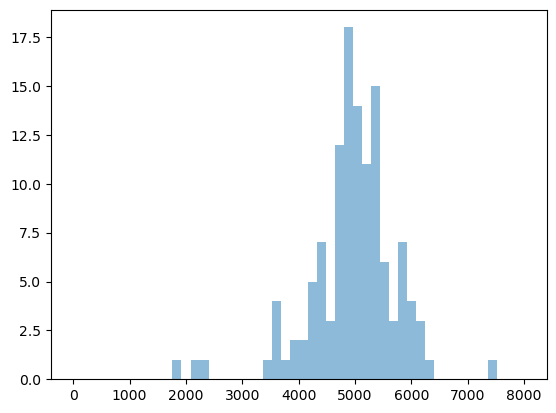

In [ ]:
## main back  = ttH , ttZ , ttW , ttbar , tzj

signal5049 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root"
signal5025 = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV_1.root"

## TW ( hadronic W )
twm_2l2nu = "/gv0/Users/achihwan/TbarWplusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_18.root"
twp_2l2nu = "/gv0/Users/achihwan/TWminusto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
tw_lnu2q = "/gv0/Users/achihwan/TbarWplustoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/tree_100.root"

## TZJ

## TTH
tth_mumu = "/gv0/Users/achihwan/TTH_Hto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8/tree_15.root"
tth_zz = "/gv0/Users/achihwan/TTH_Hto2Z_M-125_4LFilter_TuneCP5_13p6TeV_powheg2-JHUGenV752-pythia8/tree_13.root"

## TTZ
ttz_mumu = "/data6/Users/achihwan/LRSM_tb_channel/SAMPLEPRODUCTION/using_matrix/cleaning/backgroundsample/08528f47-e513-4c27-9e86-a76cdca78fe8.root "

## TTW





combined_p4, mN, mu1_pt, mu2_pt, mll = twoak8cleancut(signal)
plt.hist(ak.flatten(combined_p4), bins=50, range=(0, 8000), alpha=0.5, label='2AK8 + 2lepton Cleaned Mass Distribution')